# 학업탄력성 영향요인 연구
@author: sjh

## 1. 패키지 및 데이터 로드

In [18]:
import os
import copy
import json
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from sys import platform

import warnings
warnings.filterwarnings('ignore')

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.autolayout"] = True

# 설치된 폰트 출력
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
if 'darwin' in platform:
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'Malgun Gothic'


BASE_DIR = os.getcwd()
print('>> Current OS: ', platform)
print('>> Current WD: ', BASE_DIR)

>> Current OS:  win32
>> Current WD:  c:\Users\jhun1\Proj\Research\MixedRF


In [2]:
d = {'1': [], 'yy': []}
assert '1' in d.keys()

In [3]:
class Load:
    def __init__(self, stuFolder, schFolder, tchFolder, codeBook,
                onlyCodeBook, ):
        self.BASE_DIR = r'C:\Users\jhun1\Dropbox\[3]Project\[혼합효과 랜덤포레스트_2022]\PISA2018'

        if onlyCodeBook == False:
            print('>>>>> Init: load raw data')
            stuFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, stuFolder)) if FILE[-4:] == '.sav'][0]
            schFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, schFolder)) if FILE[-4:] == '.sav'][0]
            tchFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, tchFolder)) if FILE[-4:] == '.sav'][0]

            self.rawStu = pd.read_spss(os.path.join(self.BASE_DIR, stuFolder, stuFile))
            self.rawSCH = pd.read_spss(os.path.join(self.BASE_DIR, schFolder, schFile))
            self.rawTCH = pd.read_spss(os.path.join(self.BASE_DIR, tchFolder, tchFile))
            self.dataLS = [self.rawStu, self.rawSCH, self.rawTCH]

            # desciptive
            print('>> Stu data set', self.rawStu.shape)
            print('>> Sch data set', self.rawSCH.shape)
            print('>> Tch data set', self.rawTCH.shape)
        
        else:
            print('>> Only Codebook will be loaded')
            pass
        
        self.cb = pd.read_excel(codeBook)



    def defaultCleaner(self):
        print('\n\n>>>> Cleaning: default nation and variable')


        ### SK, US dict 형태 잡아줌
        def cleaningNational(dataLS, SouthKorea = 'Korea', US='United States'):
            nationalData = {'SK': [], 'US': []}

            for nation_name, code in zip(nationalData.keys(), [SouthKorea, US]):
                print(f'\n>> slicing: {nation_name}')
                for data in dataLS:
                    # print(data.head(5))
                    temp2 = data[data['CNTRYID'] == code]
                
                    nationalData[nation_name].append(temp2)
                    print('>> sliced shape: ', temp2.shape)
            
            return nationalData
            

        def cleaningVariable(data, codeBook):
            output = {}
            
            for nation_name in data.keys():
                Column_toSave = {'Stu': [], 'Sch': [], 'Tch': []}
                for fileName, variable, category in tqdm(zip(codeBook['file name'].values, codeBook['NAME'].values, codeBook['categories']), desc=">> variable check"):
                    # 코드북 내에서도 분석에서 제할 변수는 file name을 비움
                    if type(fileName) != str:
                        continue


                    else: 
                        if category == 'identifier':
                            Column_toSave['Stu'].append(variable)
                            
                            if variable == 'CNTSTUID':
                                continue
                            else: # 학교, 교사 셋에는 해당 변수가 없어서 추가해줌
                                Column_toSave['Sch'].append(variable)
                                Column_toSave['Tch'].append(variable)

                        else:
                            if 'STU' in fileName:
                                if variable in data[nation_name][0].columns:
                                    Column_toSave['Stu'].append(variable)
                                else:
                                    print('>> none(stu)', variable)

                            elif 'SCH' in fileName:
                                if variable in data[nation_name][1].columns:
                                    Column_toSave['Sch'].append(variable)
                                else:
                                    print('>> none(sch)', variable)

                            elif 'TCH' in fileName:
                                if variable in data[nation_name][2].columns:
                                    Column_toSave['Tch'].append(variable)
                                else:
                                    print('>> none(tch)', variable)
                    
                
                # print('>>>> save: ', Column_toSave)
                output[nation_name] = [data[nation_name][0][Column_toSave['Stu']],
                                        data[nation_name][1][Column_toSave['Sch']],
                                        data[nation_name][2][Column_toSave['Tch']],
                                        ]
                assert len(Column_toSave['Tch']) < 4, print(Column_toSave['Tch'])

            assert 'SK' in output.keys()
            assert 'US' in output.keys()
            return output

        cleaned_Nation = cleaningNational(dataLS = self.dataLS)
        self.default_cleaningData = cleaningVariable(data = cleaned_Nation, codeBook = self.cb)

        # categories 에서 일단은 codebook에 있는 변수가 다 있나 확인
        # categories 에서 individual & family, school 구분



Loader = Load(stuFolder="STU", schFolder='SCH', tchFolder='TCH',
                onlyCodeBook = False,
                codeBook=r'C:\Users\jhun1\Dropbox\[3]Project\[혼합효과 랜덤포레스트_2022]\drive-download-20220816T053902Z-001\PISA2018_CODEBOOK (변수선택-공유).xlsx'
                )

Loader.defaultCleaner()

>>>>> Init: load raw data
>> Stu data set (612004, 1119)
>> Sch data set (21903, 197)
>> Tch data set (107367, 351)


>>>> Cleaning: default nation and variable

>> slicing: SK
>> sliced shape:  (6650, 1119)
>> sliced shape:  (188, 197)
>> sliced shape:  (4068, 351)

>> slicing: US
>> sliced shape:  (4838, 1119)
>> sliced shape:  (164, 197)
>> sliced shape:  (3526, 351)


>> variable check: 97it [00:00, ?it/s]
>> variable check: 97it [00:00, ?it/s]


In [4]:
Loader.default_cleaningData.keys()

dict_keys(['SK', 'US'])

In [5]:
with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(SK).xlsx')) as writer:
    Loader.default_cleaningData['SK'][0].to_excel(writer, sheet_name='stu', index=False)
    Loader.default_cleaningData['SK'][1].to_excel(writer, sheet_name='sch', index=False)
    Loader.default_cleaningData['SK'][2].to_excel(writer, sheet_name='tch', index=False) 


with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(US).xlsx')) as writer:
    Loader.default_cleaningData['US'][0].to_excel(writer, sheet_name='stu', index=False)
    Loader.default_cleaningData['US'][1].to_excel(writer, sheet_name='sch', index=False)
    Loader.default_cleaningData['US'][2].to_excel(writer, sheet_name='tch', index=False)

# 2. Preprocessing

In [61]:
# 앞선 처리 데이터 불러오기
loadedData = {'SK': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='sch'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='tch'),
            
            ],
        'US': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='sch'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='tch'),
            ]}

>> test NA column:  SK
stu
sch
>> test NA column:  US
stu
sch


>>>> 1. Dummy coding


>>>> 2. Join DataFrame
>> join nation:  SK


>> mapping: 6650it [00:05, 1122.74it/s]


>>>> Bef:  (6650, 67) .... Aft:  (6650, 75)
>> join nation:  US


>> mapping: 4838it [00:04, 1103.56it/s]


>>>> Bef:  (4838, 67) .... Aft:  (4838, 75)


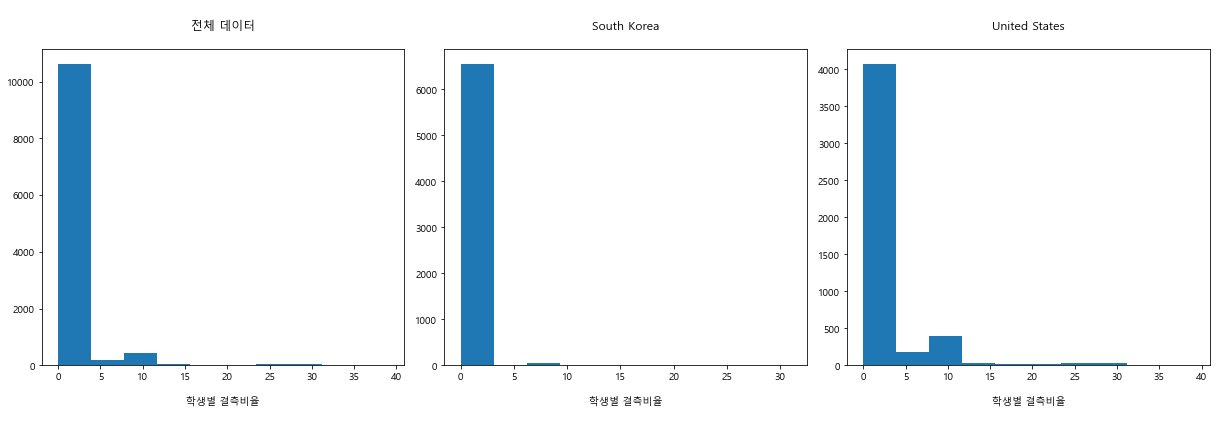



>>>> 4. Slicing data by ESCS
>> S국가.. 학업성취: 0.75, 사회경제문화수준: 0.0 기준으로 시험


AttributeError: 'str' object has no attribute 'loc'

In [85]:
class Preprocessing:
    def __init__(self, LoadedData, codeBook, dummyCodeBook):
        self.data = LoadedData
        self.cb = codeBook
        with open(dummyCodeBook, encoding='utf-8') as json_file:
            self.dummyCB = json.load(json_file)
        self.testBook = {
                    'read/math/sci_1': 'PV1MATH PV1READ PV1SCIE'.split(),
                    'read/math_1': 'PV1MATH PV1READ'.split(),
                    'read/math_10': 'PV1MATH PV2MATH PV3MATH PV4MATH PV5MATH PV6MATH PV7MATH PV8MATH PV9MATH PV10MATH PV1READ PV2READ PV3READ PV4READ PV5READ PV6READ PV7READ PV8READ PV9READ PV10READ'.split(),
                    'read_1': ['PV1READ']
                }

        self._1_dummy = {}
        self._2_joined = {}
        self._3_dropNa = {}
        self._4_ESCS = {'full': {}, 'sliced': {}} #!# 여기서 데이터 갈라야함
        self._5_shouldBeCal = {}
        
        self.rs_1_columnFull = pd.DataFrame()
        self.rs_1_columnSK = pd.DataFrame()
        self.rs_1_columnUS = pd.DataFrame()
        

    ### Needs1. is selected variable contained in both dataset
    def noDataColumn(self): # 열별로 계산
        toDrop = {}
        
        for nationName, nationalData in self.data.items():
            print('>> test NA column: ', nationName)

            toDrop[nationName] = []
            for idx, (label, inputDf) in enumerate(zip('stu sch tch'.split(), nationalData)):
                if label == 'tch':
                    continue
                else:
                    print(label)
                    for column in inputDf.columns:
                        if inputDf[column].isna().sum() > (inputDf.shape[0] * 0.8):
                            print('>>> over 80% is NA: ', column)
                            toDrop[nationName].append(column)
                        
                        elif 'missing' in inputDf[column].values:
                            print('>>> missing: ', column)
                            toDrop[nationName].append(column)
                        
                        else:
                            continue
        return toDrop
            # assert len(toDrop[nationName]) == 2, print(toDrop)


    def Dummy(self):
        # match key and value from codeBook
        print('\n\n>>>> 1. Dummy coding')
        def matchKV(codeBookDict, inputList):
            outputLS = []
            for val in inputList:
                try:
                    outputLS.append(codeBookDict[val])
                except KeyError:
                    outputLS.append(np.nan)
            
            return outputLS
        
        notDummyCol1 = self.cb[self.cb['categories'] == 'identifier'].index
        notDummyCol2 = self.cb[self.cb['categories'] == 'resilient status'].index
        notDummyCol3 = self.cb[self.cb['file name'] == 'should be caculated'].index
        
        toDummy = self.cb.drop(list(notDummyCol1)+list(notDummyCol2)+list(notDummyCol3), axis=0) # 더미 변환 안할 변수 행 삭제함
        # display(toDummy)

        for nationalName, inputNational in self.data.items():
            outputNational = copy.deepcopy(inputNational)

            for idx, row in toDummy.iterrows(): # 변수별로 반복문
                variable = row['NAME']
                
                if type(row['file name']) != str: # 분석에서 제외할 변수가 있어서 버림
                    continue

                else:
                    if ('STU' in row['file name']) and (variable in self.dummyCB['stu']):
                        outputLS = matchKV(self.dummyCB['stu'][variable], outputNational[0][variable])
                        outputNational[0][variable] = outputLS 

                # PRIVATESCH 도 마찬가지, 더미코딩할 필요 없음(코드북에도 더미코딩해두진 않음)
                # elif ('SCH' in row['file name']) and (variable in dummyCodeBook['sch']):
                #     outputLS = matchKV(dummyCodeBook['sch'][variable], outputNational[1][variable])
                #     outputNational[1][variable] = outputLS 
                    
                # elif 'TCH' in row['file name']: # tch는 더미코딩할 것 없음
            self._1_dummy[nationalName] = outputNational


    def Join(self):
        print('\n\n>>>> 2. Join DataFrame')

        for nationalName, inputNational in self._1_dummy.items():
            print('>> join nation: ', nationalName)
            inputNational[0].reset_index(drop=True, inplace=True)
            
            outputDf = copy.deepcopy(inputNational[0])
            # print('>> before ', outputDf.shape)
            before = outputDf.shape

            # if sampler.US[1].index.name == 'CNTSCHID':
            inputNational[1].drop(['CNTRYID', 'CNT'], axis=1, inplace=True)
            if inputNational[1].index.name == 'CNTSCHID':
                pass
            else:
                inputNational[1].set_index('CNTSCHID', drop=True, inplace=True)
            
            # print(inputNational[1].index)
            for idx, row in tqdm(outputDf.iterrows(), desc=">> mapping"):
                toBeInput = inputNational[1].loc[row['CNTSCHID']].values # 학생 데이터에 들어가야할 학교 데이터 찾기
                assert len(toBeInput) == inputNational[1].shape[1]
                
                toBeInput_T = toBeInput.reshape(1, 8)
                outputDf.loc[idx, list(inputNational[1].columns)] = toBeInput_T[0]
            
            # print('>> after ', outputD>f.shape)
            after = outputDf.shape
            print('>>>> Bef: ', before, '....', 'Aft: ', after)
            assert 'EDUSHORT' in outputDf.columns

            self._2_joined[nationalName] = outputDf

    def DropStudent(self):
        # 각 column 별로 데이터 검수
        def column_wise(inputData):
            if type(inputData) == dict:
                merged = pd.concat([inputData['SK'], inputData['US']])
                assert merged.shape[0] == inputData['SK'].shape[0] + inputData['US'].shape[0]
            elif type(inputData) == pd.DataFrame:
                merged = copy.deepcopy(inputData)
            
            else:
                raise TypeError('>> Error: Check your input D type')
                

            describeDF = merged.describe().T
            describeDF['NA_ratio'] = round(
                100 - describeDF['count']/merged.shape[0]*100,
                 2
                 )

            newColumnOrder = [describeDF.columns[0], 'NA_ratio'] + list(describeDF.columns[1:-1])
            describeDF= describeDF[newColumnOrder]
            return describeDF

        #!# 각 학생별로 데이터 검수
        def row_wise(inputData):
            merged = pd.concat([inputData['SK'], inputData['US']])
            assert merged.shape[0] == inputData['SK'].shape[0] + inputData['US'].shape[0]
            # unlike column wise, we prepare data with 

            for_histogram = {}
            for label, data in zip(['full', 'SK', 'US'], [merged, inputData['SK'], inputData['US']]):
                for_histogram[label] = []

                for i in range(len(data.index)) :
                    for_histogram[label].append(data.iloc[i].isnull().sum())

            fig = plt.figure(figsize=(17,6))

            plt.subplot(1, 3, 1)
            plt.hist(for_histogram['full'])
            plt.title('\n전체 데이터\n')
            plt.xlabel('\n학생별 결측비율\n')
            
            
            plt.subplot(1, 3, 2)
            plt.hist(for_histogram['SK'])
            plt.title('\nSouth Korea\n')
            plt.xlabel('\n학생별 결측비율\n')
            
            plt.subplot(1, 3, 3)
            plt.hist(for_histogram['US'])
            plt.title('\nUnited States\n')
            plt.xlabel('\n학생별 결측비율\n')

            # plt.savefig(os.path.join(BASE_DIR, 'data', f'{figName}.jpg'))
            plt.show()
        
        def dropOver(inputData):
            pass
        
        self.rs_1_columnWise = column_wise(self._2_joined)
        self.rs_1_columnSK = column_wise(self._2_joined['SK'])
        self.rs_1_columnUS = column_wise(self._2_joined['US'])

        row_wise(self._2_joined)
        
    def ESCS(self):
        #!# 데이터를 두개 만들어야함, result, resultSlice
        print('\n\n>>>> 4. Slicing data by ESCS')
        def escsSlice(inputDict):
            assert type(inputDict) == dict, print('>> Error: must input Dict')
            output = {'SK': pd.DataFrame(), 'US': pd.DataFrame()}
            for nationalName, inputNational in inputDict.items():
                print('\n\n>>>> ', nationalName)
                slicedData = copy.deepcopy(inputNational)
                escsVar = slicedData['ESCS'].quantile(0.25)
                
                before = slicedData.shape[0]
                toDrop = []
                for idx, val in enumerate(slicedData['ESCS'].values):
                    if val < escsVar:
                        continue
                    else:
                        toDrop.append(idx) # escs 하위 25%를 넘는 친구들은 버림
                
                slicedData.drop(toDrop, axis=0, inplace=True)
                output[nationalName] = slicedData
                after = slicedData.shape[0]
                print('>> before: ', before, '>> after: ', after)
            
            return output

        def quantileCalculator( 
                            inputData, # 전체 Full, escs 하위 25%로 데이터셋이 2개로 나뉘므로 인풋을 줘야함
                            targetColumn, # 어떻게 변수를 넣어서 테스트할 것인지
                            figName, # 그림 제목
                            escsThreshold = 0.25, # 경제적 퀀타일 
                            acadThreshold = 0.75 # 학문적 퀀타일
                            ):
            #!# escs를 다시 나누는게 아니라, 학문성취 기준으로 나눠야하는거 아냐!!!

            output = {'SK': pd.DataFrame(), 'US': pd.DataFrame()}
            for nationalName, inputNational in inputData:
                print(f'>> {nationalName}국가.. 학업성취: {acadThreshold}, 사회경제문화수준: {escsThreshold} 기준으로 시험')
                
                inputNational['AcademicScore'] = inputNational.loc[:, targetColumn].mean(axis=1)
                acadVar = inputNational['AcademicScore'].quantile(acadThreshold)
                escsVar = inputNational['ESCS'].quantile(escsThreshold)
                total = inputNational.shape[0]

                #!# 이게 단순히 count가 아니라, 이걸 계산해서 column으로 넣어야함,
                #!# 그림은 그 column을 기반으로 그릴 수 있도록 재조정
                
                iamResilient = []
                for idx, row in inputNational.iterrows():
                    if row['AcademicScore'] > acadVar and row['ESCS'] < escsVar:
                        iamResilient.append(1)
                    else:
                        iamResilient.append(0)
                
                print('\n>>>> 회복탄력성 학생수: ', len(iamResilient), f'({round(len(iamResilient)/total*100, 2)})%')
                fig = plt.figure(figsize=(17,9))

                plt.subplot(1, 2, 1)
                plt.hist(inputNational['AcademicScore'])
                plt.title('\n학업성취\n')
                plt.xlabel('\n점수평균\n')
                plt.axvline(acadVar, color='r', linewidth=1, linestyle='--')
                
                plt.subplot(1, 2, 2)
                plt.hist(inputNational['ESCS'])
                plt.title('\n사회문화경제\n')
                plt.xlabel('\n점수\n')
                plt.axvline(escsVar, color='r', linewidth=1, linestyle='--')

                plt.savefig(os.path.join(BASE_DIR, 'data', f'{figName}.jpg'))
                plt.show()

                output[nationalName] = inputNational

            return output
        
        self._4_ESCS['full'] = copy.deepcopy(self._3_dropNa)
        self._4_ESCS['sliced'] = escsSlice(self._3_dropNa)
        self._4_ESCS['full'] = quantileCalculator(inputData=self._4_ESCS['full'], targetColumn=self.testBook['read_1'], figName ='읽1')
        self._4_ESCS['sliced'] = quantileCalculator(inputData=self._4_ESCS['sliced'], targetColumn=self.testBook['read_1'], figName ='읽1', escsThreshold=0.0)

    
    # should be calculated 변수들 계산하는 것임
    def shouldBeCalculated(self):
        self.rs = {}

        
        def schoolMean(inputDf, whichVar):
            assert type(whichVar) == list
            outputMean = {}
            for sch_id in inputDf['CNTSCHID'].values:
                # print('>> ', sch_id)
                if sch_id in outputMean.keys():
                    continue
                
                else:
                    temp1 = inputDf[inputDf['CNTSCHID'] == sch_id]
                    temp2 = temp1.loc[:, whichVar] 
                    assert len(temp2.columns) == len(whichVar)
                    meanVal = np.nanmean(temp2.values)
                    assert type(meanVal) == np.float64, print('Error : ', type(meanVal))

                    outputMean[sch_id] = meanVal
            
            return outputMean
        
        
        def meanMapping(inputColumn, mean_dict):
            outputLS = []
            for idx, sch_id in enumerate(inputColumn.values):
                outputLS.append(mean_dict[sch_id])

            return outputLS
        
        shouldBeCal = self.cb[self.cb['file name'] == 'should be caculated']
        assert len(shouldBeCal) == 2, print('Error: check self.cb')

        for national in self.rs.keys():
            print('\n\n>> ', national)
            beforeShape = self.rs[national][1].shape[1]
            toSave = {'self': []}
            calVal = list(self.cb[self.cb['categories'] == 'resilient status']['NAME'])
            calVal.remove('ESCS')
            
            for variable in shouldBeCal['NAME'].values:
            
                if variable == 'AVG_S_TEST':    
                    mean_dict = schoolMean(self.rs[national][0], calVal)
                    print(f'>> {variable} len: ', len(mean_dict.keys()))
                    
                elif variable == 'AVG_S_ESCS':
                    mean_dict = schoolMean(self.rs[national][0], ['ESCS'])
                    print(f'>> {variable} len: ', len(mean_dict.keys()))

                #평균 dict 활용해서 매칭 진행
                outputLS = meanMapping(self.rs[national][1]['CNTSCHID'], mean_dict)
                assert len(outputLS) == self.rs[national][1].shape[0], print('Error: ', len(outputLS))
                # print(outputLS[:10])
                self.rs[national][1][variable] = outputLS # 학교 데이터이므로, 학교에 맞춰서 추가하기

            afterShape = self.rs[national][1].shape[1]
            assert afterShape - beforeShape == 2, print('Beofre: ', beforeShape, ' ... ', 'After: ', afterShape)

processor = Preprocessing(LoadedData=loadedData, codeBook=Loader.cb, dummyCodeBook='dummyCoding.json')
processor.noDataColumn()
processor.Dummy()
processor.Join()
processor.DropStudent()
processor.ESCS()
# processor.shouldBeCalculated() 

In [7]:
# with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(SK).xlsx')) as writer:
#     finalRS['SK'][0].to_excel(writer, sheet_name='stu', index=False)
#     finalRS['SK'][1].to_excel(writer, sheet_name='sch', index=False)
#     finalRS['SK'][2].to_excel(writer, sheet_name='tch', index=False)


# with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(US).xlsx')) as writer:
#     finalRS['US'][0].to_excel(writer, sheet_name='stu', index=False)
#     finalRS['US'][1].to_excel(writer, sheet_name='sch', index=False)
#     finalRS['US'][2].to_excel(writer, sheet_name='tch', index=False)

with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'descriptive(Full).xlsx')) as writer:
    processor.rs_1_columnFull.to_excel(writer, sheet_name='dsec_full', index=False)
    processor.rs_1_columnSK.to_excel(writer, sheet_name='dsec_SK', index=False)
    processor.rs_1_columnUS.to_excel(writer, sheet_name='dsec_US', index=False)


# EDA
## Dependent Var
- test option

In [ ]:
# 앞선 처리 데이터 불러오기
finalRS = {'SK': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK)_2.xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK)_2.xlsx'), sheet_name='sch'),
            # pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK)_2.xlsx'), sheet_name='tch'),
            
            ],
        'US': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US)_2.xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US)_2.xlsx'), sheet_name='sch'),
            # pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US)_2.xlsx'), sheet_name='tch'),
            ]}



>>>>  US
>> before:  4838 >> after:  1192


>>>>  SK
>> before:  6650 >> after:  1657
>> US국가.. 학업성취: 0.0, 사회경제문화수준: 0.25 기준으로 시험
>> 학업성취 기준:  161.343
>> ESCS 기준:  -1.5780500000000002

>>>> 회복탄력성 학생수:  298 (25.0)%


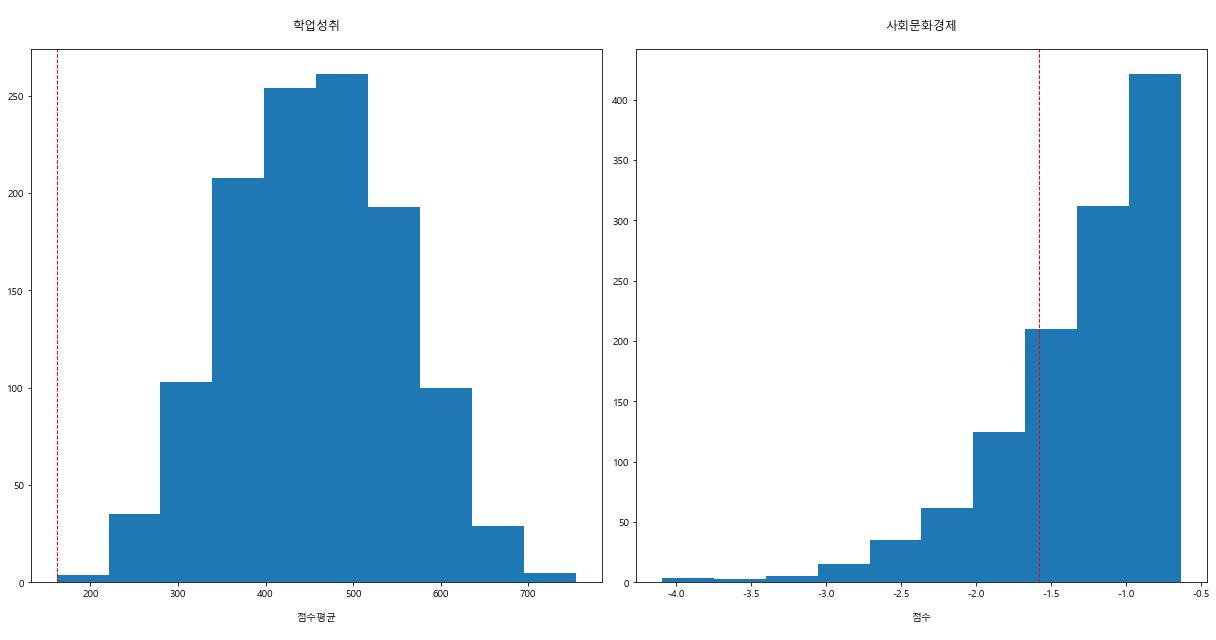

>> SK국가.. 학업성취: 0.0, 사회경제문화수준: 0.25 기준으로 시험
>> 학업성취 기준:  219.067
>> ESCS 기준:  -1.1925

>>>> 회복탄력성 학생수:  413 (24.92)%


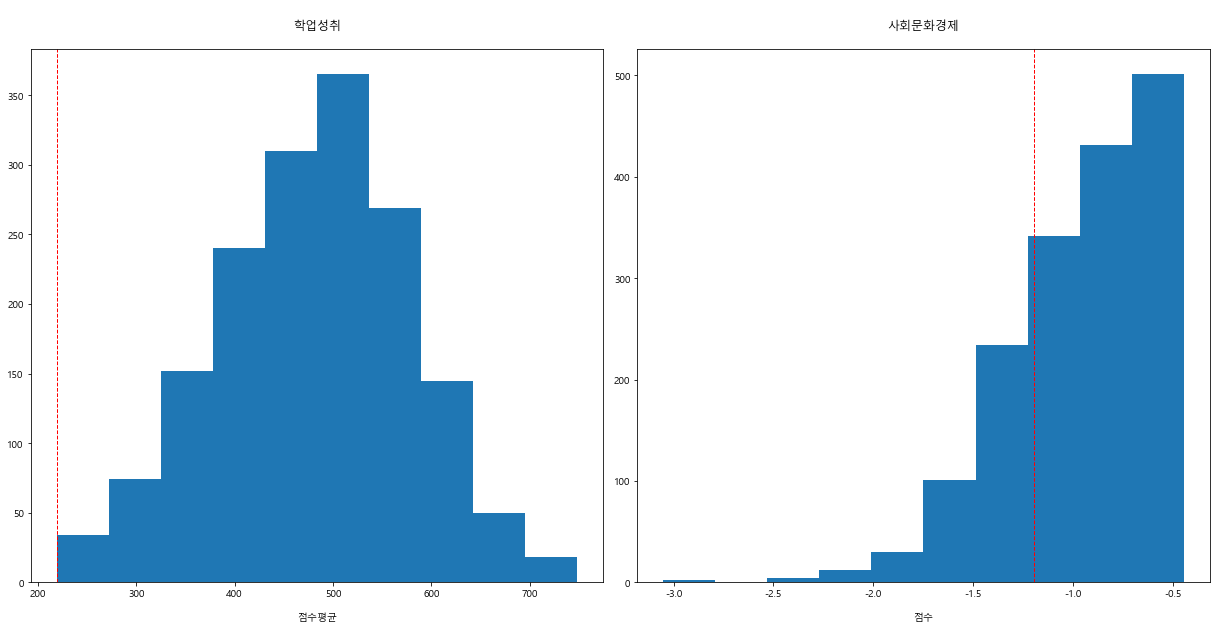

>> US국가.. 학업성취: 0.0, 사회경제문화수준: 0.25 기준으로 시험
>> 학업성취 기준:  161.343
>> ESCS 기준:  -1.5780500000000002

>>>> 회복탄력성 학생수:  298 (25.0)%


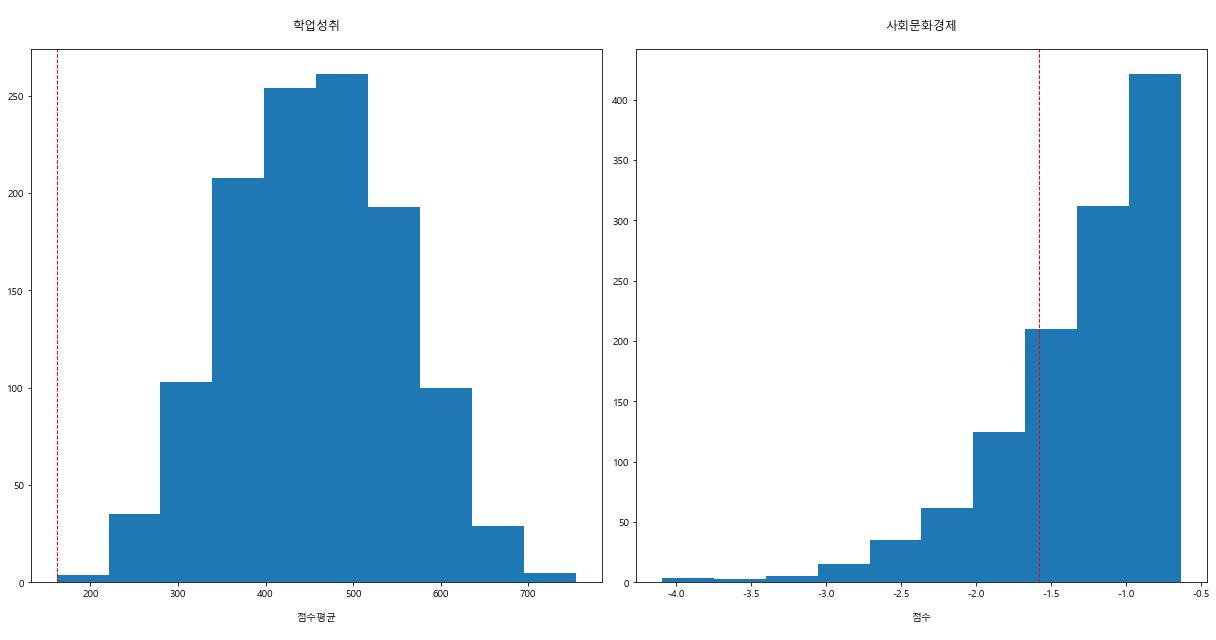

>> SK국가.. 학업성취: 0.0, 사회경제문화수준: 0.25 기준으로 시험
>> 학업성취 기준:  219.067
>> ESCS 기준:  -1.1925

>>>> 회복탄력성 학생수:  413 (24.92)%


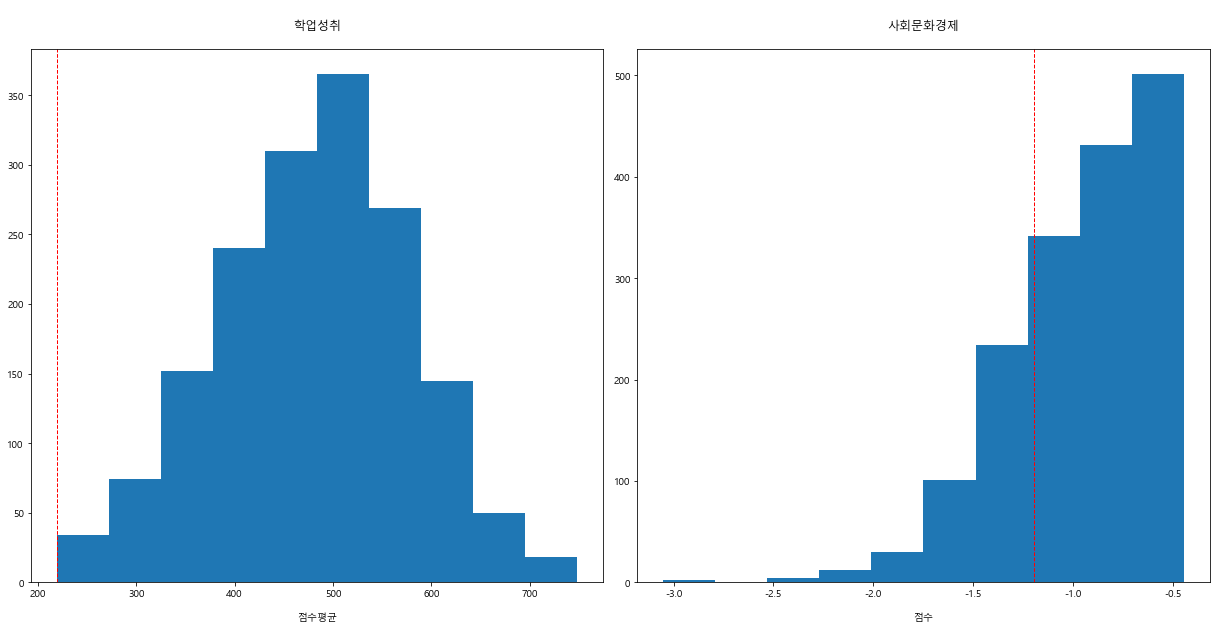

In [46]:


class Sampling:
    def __init__(self, finalRS, codeBook, testBook):
        self.nationalLS = ['US', 'SK']
        self.US = finalRS['US']
        self.SK = finalRS['SK']
        self.cb = codeBook
        self.tb = testBook
        self.result = {}
        self.resultSlice = {}
    
    # def quantile(self):

    #     for dataSet in [self.result, self.resultSlice]:


sampler = Sampling(finalRS=finalRS, codeBook=dataSet.cb, testBook=testBook)
sampler.escsSlice()
sampler.quantileCalculator( targetColumn=testBook['read_1'], figName ='읽1')

In [ ]:
with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'dummyed(SK).xlsx')) as writer:
    dummyedRS['SK'][0].to_excel(writer, sheet_name='stu', index=False)
    dummyedRS['SK'][1].to_excel(writer, sheet_name='sch', index=False)
    dummyedRS['SK'][2].to_excel(writer, sheet_name='tch', index=False)


with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'dummyed(US).xlsx')) as writer:
    dummyedRS['US'][0].to_excel(writer, sheet_name='stu', index=False)
    dummyedRS['US'][1].to_excel(writer, sheet_name='sch', index=False)
    dummyedRS['US'][2].to_excel(writer, sheet_name='tch', index=False)

## Descriptive Statics

In [ ]:
def descriptiveGen(TYPE, inputArr):
    # print(type(inputArr))
    if TYPE == 'NUM':
        nullCount = 0
        for val in inputArr:
            if val != val:
                nullCount += 1

        # nanmean, nanstd를 써야 무시됨
        return [len(inputArr)- nullCount, nullCount, np.nanmean(inputArr), np.nanstd(inputArr)]

    elif TYPE == 'CHAR':
        # print(inputArr)
        counter = {}
        nullCount = 0
        for val in inputArr:
            if (val != val) or (val == 'missing'): # nan만 본인과 본인이 다름
                nullCount += 1

            else:
                if val in counter.keys():
                    counter[val] += 1
                else:
                    counter[val] = 1
        print(counter)
        return [len(inputArr)-nullCount, nullCount, counter]
        

def descriptive(inputNational, codeBook):
    [df.reset_index(drop=True, inplace=True) for df in inputNational]

    outputCodebook = copy.deepcopy(codeBook)

    for idx, row in codeBook.iterrows():
        # 계산하지 않아도 되는 영역은 피함
        if (row['categories'] == 'identifier') or (row['categories'] == 'resilient status'):
            continue

        else:
            variableName = row['NAME']
            
            # calculate descriptive
            if 'STU' in row['file name']:    
                output = descriptiveGen(row['TYPE'], inputNational[0][variableName].values)
                
            elif 'SCH' in row['file name']:
                output = descriptiveGen(row['TYPE'], inputNational[1][variableName].values)
                
            elif 'TCH' in row['file name']:
                output = descriptiveGen(row['TYPE'], inputNational[2][variableName].values)

            # write
            if len(output) == 4: # 누머릭인 경우
                outputCodebook.loc[idx, '빈도'] = round(output[0], 0)
                outputCodebook.loc[idx, '결측'] = round(output[1], 0)
                outputCodebook.loc[idx, '평균'] = round(output[2], 2)
                outputCodebook.loc[idx, '표준편차'] = round(output[3], 2)

            elif len(output) == 3: # 스트링인 경우
                outputCodebook.loc[idx, '빈도'] = round(output[0], 0)
                outputCodebook.loc[idx, '결측'] = round(output[1], 0)
                outputCodebook.loc[idx, '분포'] = str(output[2])


    return outputCodebook

descriptiveSK = descriptive(dummyedRS['SK'], codeBook = dataSet.cb)
descriptiveUS = descriptive(dummyedRS['US'], codeBook = dataSet.cb)

with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'codebookWithDesc.xlsx')) as writer:
    descriptiveSK.to_excel(writer, sheet_name='sk', index=False)
    descriptiveUS.to_excel(writer, sheet_name='us', index=False)

In [ ]:
#!#
## 학생데이터를 기준으로 데이터를 쭉 합치는 코드를 만들어야함
#!#